<a href="https://colab.research.google.com/github/aetev/Learning-stuff-/blob/main/xgboostregression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install histdata

In [70]:
import pandas as pd
from histdata import download_hist_data as dl
from histdata.api import Platform as P, TimeFrame as TF
import zipfile
import numpy as np
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [31]:
test = dl(year='2005', month=None, pair='eurusd', platform=P.GENERIC_ASCII, time_frame=TF.ONE_MINUTE)


https://www.histdata.com/download-free-forex-historical-data/?/ascii/1-minute-bar-quotes/eurusd/2005
{'tk': 'e2485aa73bdae4dd226cbabb4b24d38e', 'date': '2005', 'datemonth': '2005', 'platform': 'ASCII', 'timeframe': 'M1', 'fxpair': 'EURUSD'}
Wrote to ./DAT_ASCII_EURUSD_M1_2005.zip


In [37]:
zf = zipfile.ZipFile(test)
zf = zf.open('DAT_ASCII_EURUSD_M1_2005.csv')
df = pd.read_csv(zf, sep=';', header=0, names=['DateTime Stamp', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'Volume'])

In [40]:
# Convert 'points' column to NumPy array
column_to_numpy = df['CLOSE'].to_numpy()

# Print result
print(column_to_numpy)

[1.3466 1.3468 1.3468 ... 1.1842 1.1841 1.1843]


In [44]:
change = np.diff(column_to_numpy)
change = change/np.std(change)
print(change)

[ 0.98117217  0.          0.49058608 ... -0.49058608 -0.49058608
  0.98117217]


In [101]:
# Define the window shape
window_shape = (61,)

# Create a sliding window view of the array
window_view = np.lib.stride_tricks.sliding_window_view(change, window_shape)
print(window_view)

[[ 0.98117217  0.          0.49058608 ...  1.96234433  2.45293042
   4.41527475]
 [ 0.          0.49058608  0.49058608 ...  2.45293042  4.41527475
  -0.49058608]
 [ 0.49058608  0.49058608  2.45293042 ...  4.41527475 -0.49058608
  -1.47175825]
 ...
 [-0.49058608  0.         -0.49058608 ... -1.47175825  0.
  -0.49058608]
 [ 0.         -0.49058608  0.49058608 ...  0.         -0.49058608
  -0.49058608]
 [-0.49058608  0.49058608  0.49058608 ... -0.49058608 -0.49058608
   0.98117217]]


In [102]:
# Pop the last value in each window into a separate array
last_values = window_view[:, -1]
# Remove the last value from each window
window_view_no_last = np.delete(window_view, -1, axis=1)

print(last_values)
print(window_view_no_last)

[ 4.41527475 -0.49058608 -1.47175825 ... -0.49058608 -0.49058608
  0.98117217]
[[ 0.98117217  0.          0.49058608 ...  0.98117217  1.96234433
   2.45293042]
 [ 0.          0.49058608  0.49058608 ...  1.96234433  2.45293042
   4.41527475]
 [ 0.49058608  0.49058608  2.45293042 ...  2.45293042  4.41527475
  -0.49058608]
 ...
 [-0.49058608  0.         -0.49058608 ...  0.         -1.47175825
   0.        ]
 [ 0.         -0.49058608  0.49058608 ... -1.47175825  0.
  -0.49058608]
 [-0.49058608  0.49058608  0.49058608 ...  0.         -0.49058608
  -0.49058608]]


In [103]:
model = XGBRegressor()

In [104]:
model.fit(window_view_no_last, last_values)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [105]:
predictions = model.predict(window_view_no_last)

In [106]:
# Calculate MAE
mae = mean_absolute_error(last_values, predictions)
print('Mean Absolute Error:', mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(last_values, predictions))
print('Root Mean Squared Error:', rmse)

# Calculate R-squared
r2 = r2_score(last_values, predictions)
print('R-squared:', r2)

Mean Absolute Error: 0.6370300929492699
Root Mean Squared Error: 0.9555296430155412
R-squared: 0.08669611087873164


(50800.0, 51000.0)

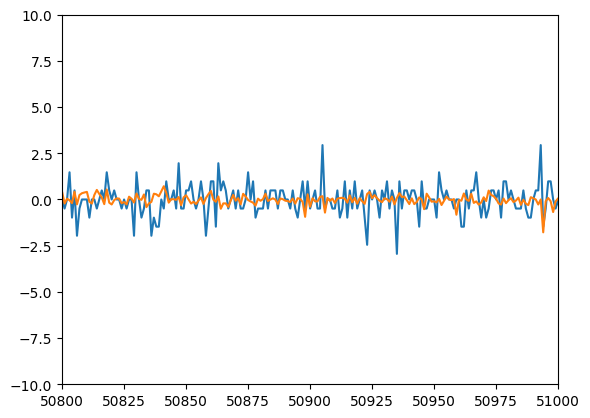

In [117]:
plt.plot(last_values)
plt.plot(predictions*10)
plt.ylim(-10,10)
plt.xlim(50800,51000)